In [3]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.metrics import SCORERS
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#from lightgbm import LGBMRegressor
#import xgboost as xgb


#next: try boosting algorithms, and gridsearch aiming to improve SVC or even better reduces forests overfitting
#download 2022 squads to make predictions

In [24]:
#loading data and retaining only significant columns
df=pd.read_csv('NBA_Pts.csv', sep=';', decimal=',')
df=df[df['Team2']!='nok'][['Season_endyear', 'Player', 'Pos', 'Age', 'G', 'PTS', 'Team2']]
df.head(5)

,Season_endyear,Player,Pos,Age,G,PTS,Team2
0,2010,Arron Afflalo,SG,24,82,8.829268,DEN
1,2010,Alexis Ajinça,C,21,6,1.666667,CHO
2,2010,LaMarcus Aldridge,PF,24,78,17.858974,POR
3,2010,Joe Alexander,SF,23,8,0.500000,CHI
4,2010,Malik Allen,PF,31,51,2.058824,DEN


In [25]:
#searching for serious injuries through game tresholds

df_games=df.copy()
#for year in range(5):
for year in range(3):
    df_games['G-'+str(year+1)]=(df_games.sort_values(by=['Season_endyear'], ascending=True).groupby(['Player'])['G'].shift(year+1))

df_games['pts_injury_adjusted']=np.where(df_games['G']/df_games['G-1']<0.5, 1, 0)
#df_games['std']=df_games[['G-1','G-2','G-3','G-4','G-5']].std(axis=1)
#df_games['hist']=((df_games['G']-df_games['mean'])/df_games['mean'])
#df_games['low_tres']=df_games['mean']-df_games['std']
#df_games[df_games['Player']=='Stephen Curry']
#df_games[df_games['Player']=='Kawhi Leonard']
#df_games[df_games['hist']<1]['hist'].hist(bins=50)
df_games

,Season_endyear,Player,Pos,Age,G,PTS,Team2,G-1,G-2,G-3,pts_injury_adjusted
0,2010,Arron Afflalo,SG,24,82,8.829268,DEN,74.0,NaN,NaN,0
1,2010,Alexis Ajinça,C,21,6,1.666667,CHO,31.0,NaN,NaN,1
2,2010,LaMarcus Aldridge,PF,24,78,17.858974,POR,81.0,NaN,NaN,0
3,2010,Joe Alexander,SF,23,8,0.500000,CHI,59.0,NaN,NaN,1
4,2010,Malik Allen,PF,31,51,2.058824,DEN,49.0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
8067,2011,Dorell Wright,SF,25,82,16.390244,GSW,72.0,6.0,NaN,0
8068,2011,Julian Wright,SF,23,52,3.615385,TOR,68.0,54.0,NaN,0
8069,2011,Nick Young,SG,25,64,17.421875,WAS,74.0,82.0,NaN,0
8070,2011,Sam Young,SF,25,78,7.333333,MEM,80.0,NaN,NaN,0


In [26]:
#creating last 5 years data


#for year in range(5):
for year in range(3):
    df['PTS_year-'+str(year+1)]=(df.sort_values(by=['Season_endyear'], ascending=True).groupby(['Player'])['PTS'].shift(year+1))

"""
#test - adjusting for injuries
df['PTS_y']=df['PTS']
df2=df.merge(df_games[['Season_endyear', 'Player', 'pts_injury_adjusted']], on=['Season_endyear', 'Player'])
#df2['mean']=df2[['PTS_year-1', 'PTS_year-2', 'PTS_year-3', 'PTS_year-4', 'PTS_year-5']].mean(axis=1)
df2['mean']=df2[['PTS_year-1', 'PTS_year-2', 'PTS_year-3']].mean(axis=1)
df2['PTS']=np.where(df2['pts_injury_adjusted']==0, df2['PTS'], df2['mean'])
#for year in range(5):
for year in range(3):
    df2['PTS_year-'+str(year+1)]=(df2.sort_values(by=['Season_endyear'], ascending=True).groupby(['Player'])['PTS'].shift(year+1))

df=df2.drop(['pts_injury_adjusted', 'mean'], axis=1)
#df2[df2['Player']=='Stephen Curry']
df[df['Player']=='Stephen Curry']
"""
df[df['Player']=='Stephen Curry']

,Season_endyear,Player,Pos,Age,G,PTS,Team2,PTS_year-1,PTS_year-2,PTS_year-3
120,2010,Stephen Curry,PG,21,80,17.487500,GSW,NaN,NaN,NaN
1311,2021,Stephen Curry,PG,32,63,32.000000,GSW,20.800000,27.300000,26.400000
2023,2020,Stephen Curry,PG,31,5,20.800000,GSW,27.300000,26.400000,25.303797
2675,2019,Stephen Curry,PG,30,69,27.300000,GSW,26.400000,25.303797,30.063291
3370,2018,Stephen Curry,PG,29,51,26.400000,GSW,25.303797,30.063291,23.750000
4008,2017,Stephen Curry,PG,28,79,25.303797,GSW,30.063291,23.750000,24.012821
4599,2016,Stephen Curry,PG,27,79,30.063291,GSW,23.750000,24.012821,22.897436
5196,2015,Stephen Curry,PG,26,80,23.750000,GSW,24.012821,22.897436,14.730769
5861,2014,Stephen Curry,PG,25,78,24.012821,GSW,22.897436,14.730769,18.554054
6442,2013,Stephen Curry,PG,24,78,22.897436,GSW,14.730769,18.554054,17.487500


In [103]:
#creating the yearly current team past total ppg

#df_team=df.groupby(['Season_endyear', 'Team2'])[['PTS_year-1','PTS_year-2','PTS_year-3','PTS_year-4','PTS_year-5']].sum().reset_index()
df_team=df.groupby(['Season_endyear', 'Team2'])[['PTS_year-1','PTS_year-2','PTS_year-3']].sum().reset_index()


#creating the yearly team-pos total ppg
#df_pos=df.groupby(['Season_endyear', 'Team2', 'Pos'])[['PTS_year-1','PTS_year-2','PTS_year-3','PTS_year-4','PTS_year-5']].sum().reset_index()
df_pos=df.groupby(['Season_endyear', 'Team2', 'Pos'])[['PTS_year-1','PTS_year-2','PTS_year-3']].sum().reset_index()

#creating player bins
df_bins=df[['Season_endyear', 'Team2', 'PTS']].copy()
for pts in [10, 15, 20, 25, 30]:
    df_bins['bin_'+str(pts)]=np.where(df_bins['PTS']>=pts,1,0)
df_bins=df_bins.groupby(['Season_endyear', 'Team2']).sum().reset_index().drop('PTS', axis=1)

#for year in range(5):
for year in range(3):
    for bins in [10, 15, 20, 25, 30]:
        df_bins['bin_'+str(bins)+'-'+str(year+1)]=(df_bins.sort_values(by=['Season_endyear'], ascending=True).groupby(['Team2'])['bin_'+str(bins)].shift(year+1))


#creating year-1 bins (bins of this seasons players last season)
df_bins2=df[['Season_endyear', 'Team2', 'PTS_year-1']].copy()
for pts in [10, 15, 20, 25, 30]:
    df_bins2['bin_'+str(pts)]=np.where(df_bins2['PTS_year-1']>=pts,1,0)
df_bins2=df_bins2.groupby(['Season_endyear', 'Team2']).sum().reset_index().drop('PTS_year-1', axis=1)

#for year in range(5):
for year in range(3):
    for bins in [10, 15, 20, 25, 30]:
        df_bins['bin_'+str(bins)+'-'+str(year+1)]=(df_bins.sort_values(by=['Season_endyear'], ascending=True).groupby(['Team2'])['bin_'+str(bins)].shift(year+1))


#merging in the final dataframe
df_stats=df.merge(df_team, on=['Season_endyear', 'Team2'], suffixes=('','_team'))
df_stats=df_stats.merge(df_pos, on=['Season_endyear', 'Team2', 'Pos'], suffixes=('','_pos'))
df_stats=df_stats.merge(df_bins, on=['Season_endyear', 'Team2'])
df_stats=df_stats.merge(df_bins2, on=['Season_endyear', 'Team2'], suffixes=('','_-1'))
df_stats.head(5)

#drop season prior to 2013 for lack of data
df_stats=df_stats[df_stats['Season_endyear']>2013]

#adjusting team data in order for it to not account for the player on each line
for year in range(3):
    df_stats['PTS_year-'+str(year+1)+'_team']= df_stats['PTS_year-'+str(year+1)+'_team']- df_stats['PTS_year-'+str(year+1)]
    df_stats['PTS_year-'+str(year+1)+'_pos']= df_stats['PTS_year-'+str(year+1)+'_pos']- df_stats['PTS_year-'+str(year+1)]

#replacing NA with 0. Usually it will mean a new player, sometimes can account for long-term injuries. But let's see how it goes

df_stats=df_stats.fillna(0)
df_stats[df_stats['Player']=='Stephen Curry']
df_rank[(df_rank['Team2']=='GSW') & (df_rank['Season_endyear']==2021)]

,Season_endyear,Player,Pos,Age,G,Team2,PTS_year-1_team,PTS_year-2_team,PTS_year-3_team,PTS_year-1_pos,...,bin_15_-1,bin_20_-1,bin_25_-1,bin_30_-1,rank,PTS,PTS_y,PTS_year-1,PTS_year-2,PTS_year-3
118,2021,Kelly Oubre Jr.,SF,25,55,GSW,138.9,87.4,93.4,8.8,...,3,2,0,0,3.0,15.4,15.4,18.700000,15.2,0.0
120,2021,Andrew Wiggins,PF,25,71,GSW,135.8,84.5,87.5,35.5,...,3,2,0,0,2.0,18.6,18.6,21.800000,18.1,17.7
121,2021,Stephen Curry,PG,32,63,GSW,136.8,75.3,78.8,21.8,...,3,2,0,0,1.0,32.0,32.0,26.334599,27.3,26.4


In [104]:

#test - adjusting for injuries - which should only be done after the team aggregated stats. Therefore, it changed place 
df_stats['PTS_y']=df_stats['PTS']
df2=df_stats.merge(df_games[['Season_endyear', 'Player', 'pts_injury_adjusted']], on=['Season_endyear', 'Player'])
#df2['mean']=df2[['PTS_year-1', 'PTS_year-2', 'PTS_year-3', 'PTS_year-4', 'PTS_year-5']].mean(axis=1)
df2['mean']=df2[['PTS_year-1', 'PTS_year-2', 'PTS_year-3']].mean(axis=1)
df2['PTS']=np.where(df2['pts_injury_adjusted']==0, df2['PTS'], df2['mean'])
#for year in range(5):
for year in range(3):
    df2['PTS_year-'+str(year+1)]=(df2.sort_values(by=['Season_endyear'], ascending=True).groupby(['Player'])['PTS'].shift(year+1))

df_stats2=df_stats.drop(['PTS', 'PTS_y', 'PTS_year-1', 'PTS_year-2', 'PTS_year-3'], axis=1).merge(df2[['Season_endyear', 'Player', 'PTS', 'PTS_y', 'PTS_year-1', 'PTS_year-2', 'PTS_year-3']], on=['Season_endyear', 'Player'])
df_stats=df_stats2
df_stats=df_stats.fillna(0)
df_stats=df_stats[df_stats['PTS_year-1']>5]

#rank in team with last season's points
df_rank=df_stats.copy()
df_rank['rank']=df_rank.groupby(["Season_endyear", 'Team2'])["PTS_year-1"].rank("dense", ascending=False)
df_stats=df_stats.merge(df_rank[["Season_endyear", 'Player', 'rank']], on=["Season_endyear", 'Player'])


df2[df2['Player']=='Stephen Curry']
df_stats[df_stats['Player']=='Stephen Curry']


,Season_endyear,Player,Pos,Age,G,Team2,PTS_year-1_team,PTS_year-2_team,PTS_year-3_team,PTS_year-1_pos,...,bin_15_-1,bin_20_-1,bin_25_-1,bin_30_-1,PTS,PTS_y,PTS_year-1,PTS_year-2,PTS_year-3,rank
218,2021,Stephen Curry,PG,32,63,GSW,136.800000,75.300000,78.800000,21.800000,...,3,2,0,0,32.000000,32.000000,26.334599,27.300000,26.400000,1.0
577,2020,Stephen Curry,PG,31,5,GSW,93.294872,88.132867,61.912245,33.394872,...,2,2,1,0,26.334599,20.800000,27.300000,26.400000,25.303797,1.0
922,2019,Stephen Curry,PG,30,69,GSW,133.400000,114.117066,115.976623,15.000000,...,4,4,3,0,27.300000,27.300000,26.400000,25.303797,30.063291,1.0
1211,2018,Stephen Curry,PG,29,51,GSW,119.570059,119.124085,119.299474,10.761278,...,3,3,2,0,26.400000,26.400000,25.303797,30.063291,23.750000,1.0
1580,2017,Stephen Curry,PG,28,79,GSW,109.115407,112.884991,114.253707,6.256410,...,3,3,2,1,25.303797,25.303797,30.063291,23.750000,24.012821,1.0
1772,2016,Stephen Curry,PG,27,79,GSW,98.316221,87.577457,85.225708,5.910256,...,2,2,0,0,30.063291,30.063291,23.750000,24.012821,0.000000,1.0
2075,2015,Stephen Curry,PG,26,80,GSW,101.072938,92.828209,91.472547,8.276316,...,3,1,0,0,23.750000,23.750000,24.012821,0.000000,0.000000,1.0


In [124]:
#separating train and test sets

#cols=['Age', 'PTS_year-1_team', 'PTS_year-2_team', 'PTS_year-3_team',
  #     'PTS_year-1_pos', 'PTS_year-2_pos', 'PTS_year-1', 'PTS_year-2']

cols=['Age', 
       'PTS_year-1_team', 
       'PTS_year-1_pos', 'bin_10-1', 'bin_15-1',
       'bin_20-1', 'bin_25-1', 'bin_30-1', 'bin_10-2', 'bin_15-2', 'bin_20-2',
       'bin_25-2', 'bin_30-2', 'bin_10-3', 'bin_15-3', 'bin_20-3', 'bin_25-3',
       'bin_30-3', 'bin_10_-1', 'bin_15_-1', 'bin_20_-1', 'bin_25_-1',
       'bin_30_-1', 'PTS_year-1', 'PTS_year-2', 'PTS_year-3',
       'rank']

X=df_stats[df_stats['Season_endyear']<2021].drop(['Season_endyear', 'Player', 'G', 'Team2', 'Pos', 'PTS', 'PTS_y', 'bin_10', 'bin_15', 'bin_20', 'bin_25', 'bin_30'], axis=1)
X_oot=df_stats[df_stats['Season_endyear']==2021].drop(['Season_endyear', 'Player', 'G', 'Team2','Pos', 'PTS', 'PTS_y','bin_10', 'bin_15', 'bin_20', 'bin_25', 'bin_30'], axis=1)
y=df_stats[df_stats['Season_endyear']<2021]['PTS_y']
y_oot=df_stats[df_stats['Season_endyear']==2021]['PTS_y']

X=X[cols]
X_oot=X_oot[cols]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=8)
#X_train, X_test, y_train, y_test = train_test_split(X[X['PTS_year-1']>0], y[X['PTS_year-1']>0], test_size=0.33, random_state=8)



In [125]:
#training and evaluating the models
lr=LinearRegression()
sv=SVR()
rf=RandomForestRegressor()
#lgbm=lightgbm.LGBMRegressor()

r2=[]
mse=[]
models=[]
dataset=[]

for model in [rf]:
    #model.fit(X_train, y_train)
    model.fit(X,y)
    r2.append(r2_score(y_train, model.predict(X_train)))
    #r2.append(r2_score(y_test, model.predict(X_test)))
    r2.append(r2_score(y_oot, model.predict(X_oot)))
    mse.append(mean_squared_error(y_train, model.predict(X_train)))
    #mse.append(mean_squared_error(y_test, model.predict(X_test)))
    mse.append(mean_squared_error(y_oot, model.predict(X_oot)))
    dataset.append(['train', 'test', 'oot'])
    models.append([str(model),str(model),str(model)])


In [126]:
#evaluating results
r2

[0.9592864117921707, 0.7437133579155887]

In [127]:
#evaluating results
mse

[1.519546304325746, 10.869800055740615]

In [128]:
#checking 2021 predictions vs. actual

df_check=df_stats[df_stats['Season_endyear']==2021][['Player', 'PTS_y']].copy()
df_check['prediction']=rf.predict(X_oot)
df_check['error']=df_check['PTS_y']-df_check['prediction']
#df_check.sort_values(by=['prediction'], ascending=False).head(10)
df_check.sort_values(by=['error'], ascending=False).head(10)

,Player,PTS_y,prediction,error
163,De'Aaron Fox,25.2,13.302702,11.897298
297,Christian Wood,21.0,10.218019,10.781981
231,Malik Beasley,19.6,10.065234,9.534766
241,Jerami Grant,22.3,13.176250,9.123750
194,Michael Porter Jr.,19.0,10.945944,8.054056
115,Gary Trent Jr.,15.3,7.289127,8.010873
119,Chris Boucher,13.6,5.734924,7.865076
317,Jaylen Brown,24.7,17.626070,7.073930
218,Stephen Curry,32.0,24.985139,7.014861
294,Kevin Porter Jr.,16.6,9.786860,6.813140


In [129]:
#checking if we can detect big variations
df_check2=df_stats[df_stats['Season_endyear']==2021][['Player', 'PTS_y', 'PTS_year-1']].copy()
df_check2['prediction']=rf.predict(X_oot)
df_check2['error']=df_check2['PTS_y']-df_check2['prediction']
df_check2['var']=df_check2['PTS_y']-df_check2['PTS_year-1']
#df_check.sort_values(by=['prediction'], ascending=False).head(10)
df_check2=df_check2[df_check2['PTS_year-1']>0]
df_check2.sort_values(by=['var'], ascending=True).head(10)

,Player,PTS_y,PTS_year-1,prediction,error,var
307,Spencer Dinwiddie,6.7,20.600000,19.182331,-12.482331,-13.900000
313,Blake Griffin,11.0,22.491257,16.660322,-5.660322,-11.491257
314,James Harden,24.6,34.300000,31.572879,-6.972879,-9.700000
322,Jabari Parker,5.5,14.000000,13.398720,-7.898720,-8.500000
107,Rodney Hood,4.5,12.859322,10.190784,-5.690784,-8.359322
25,J.J. Redick,7.4,15.300000,12.843730,-5.443730,-7.900000
169,Hassan Whiteside,8.1,15.500000,12.913718,-4.813718,-7.400000
296,DeMarcus Cousins,8.9,16.300000,15.864844,-6.964844,-7.400000
206,Lou Williams,11.3,18.200000,17.305398,-6.005398,-6.900000
170,Glenn Robinson III,5.3,11.700000,10.122285,-4.822285,-6.400000


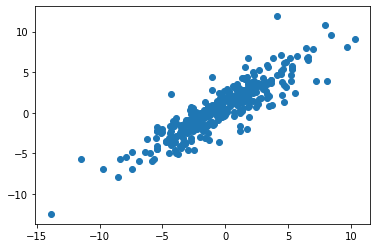

In [130]:
plt.scatter(df_check2['var'], df_check2['error'])

In [131]:
df_check[(df_check['Player'] == 'Stephen Curry') | (df_check['Player'] == 'Anthony Davis') | (df_check['Player'] == 'Russell Westbrook')| (df_check['Player'] == 'Bradley Beal')]


,Player,PTS_y,prediction,error
92,Anthony Davis,21.8,25.222705,-3.422705
138,Bradley Beal,31.3,28.244077,3.055923
150,Russell Westbrook,22.2,24.563593,-2.363593
218,Stephen Curry,32.0,24.985139,7.014861


In [206]:
df_view=df_stats[(df_stats['Season_endyear'] == 2021) & ((df_stats['Player'] == 'Stephen Curry') | (df_stats['Player'] == 'Anthony Davis') | (df_stats['Player'] == 'Russell Westbrook')| (df_stats['Player'] == 'Bradley Beal'))]
df_view.to_csv('analysis.csv')
pd.set_option('display.max_columns', 42)
df_view


,Season_endyear,Player,Pos,Age,G,Team2,PTS_year-1_team,PTS_year-2_team,PTS_year-3_team,PTS_year-1_pos,PTS_year-2_pos,PTS_year-3_pos,bin_10,bin_15,bin_20,bin_25,bin_30,bin_10-1,bin_15-1,bin_20-1,bin_25-1,bin_30-1,bin_10-2,bin_15-2,bin_20-2,bin_25-2,bin_30-2,bin_10-3,bin_15-3,bin_20-3,bin_25-3,bin_30-3,bin_10_-1,bin_15_-1,bin_20_-1,bin_25_-1,bin_30_-1,PTS,PTS_y,PTS_year-1,PTS_year-2,PTS_year-3
149,2021,Anthony Davis,PF,27,36,LAL,139.3,151.5,146.6,18.6,15.3,14.7,5,3,2,1,0,4.0,2.0,2.0,2.0,0.0,5.0,3.0,1.0,1.0,0.0,9.0,4.0,0.0,0.0,0.0,5,4,2,2,0,21.8,21.8,26.100000,25.9,28.1
216,2021,Bradley Beal,SG,27,60,WAS,150.1,98.6,73.1,10.5,3.4,0.0,5,2,2,1,1,8.0,2.0,1.0,1.0,1.0,8.0,2.0,2.0,1.0,0.0,5.0,2.0,1.0,0.0,0.0,7,3,2,2,1,31.3,31.3,30.500000,25.6,22.6
230,2021,Russell Westbrook,PG,32,65,WAS,153.4,101.3,70.3,16.0,14.2,15.4,5,2,2,1,1,8.0,2.0,1.0,1.0,1.0,8.0,2.0,2.0,1.0,0.0,5.0,2.0,1.0,0.0,0.0,7,3,2,2,1,22.2,22.2,27.200000,22.9,25.4
341,2021,Stephen Curry,PG,32,63,GSW,136.8,75.3,78.8,21.8,7.6,3.0,5,3,1,1,1,7.0,3.0,2.0,0.0,0.0,4.0,4.0,3.0,2.0,0.0,4.0,3.0,3.0,2.0,0.0,6,3,2,0,0,32.0,32.0,26.334599,27.3,26.4


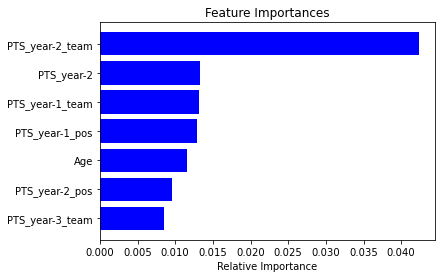

In [72]:
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)
indices=indices[-10:-1]

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Optimal number of features : 20


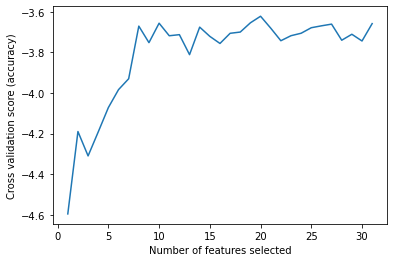

In [52]:
from sklearn.feature_selection import RFECV

# Create the RFE object and compute a cross-validated score.
rff = RandomForestRegressor()
# The "accuracy" scoring shows the proportion of correct classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=rff, step=1, cv=3,
              scoring='neg_mean_squared_error',
              min_features_to_select=min_features_to_select)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

In [53]:
rfecv.grid_scores_

array([-4.59529645, -4.18984345, -4.30978665, -4.19168641, -4.07176019,
       -3.98361811, -3.93005779, -3.67098695, -3.7523232 , -3.65661182,
       -3.71839977, -3.71300416, -3.81141463, -3.67593517, -3.72141075,
       -3.75633623, -3.70631524, -3.70021702, -3.65466026, -3.62236813,
       -3.68083493, -3.7428864 , -3.71817155, -3.70602942, -3.67888483,
       -3.66955668, -3.66118122, -3.74042715, -3.7110771 , -3.74414028,
       -3.65860587])

In [122]:
#from sklearn.feature_selection import RFE
#rfe = RFE(estimator=rff, n_features_to_select=8, step=1)
#rfe.fit(X, y)
#X.columns[rfe.get_support([])]
df_stats.columns

Index(['Season_endyear', 'Player', 'Pos', 'Age', 'G', 'Team2',
       'PTS_year-1_team', 'PTS_year-2_team', 'PTS_year-3_team',
       'PTS_year-1_pos', 'PTS_year-2_pos', 'PTS_year-3_pos', 'bin_10',
       'bin_15', 'bin_20', 'bin_25', 'bin_30', 'bin_10-1', 'bin_15-1',
       'bin_20-1', 'bin_25-1', 'bin_30-1', 'bin_10-2', 'bin_15-2', 'bin_20-2',
       'bin_25-2', 'bin_30-2', 'bin_10-3', 'bin_15-3', 'bin_20-3', 'bin_25-3',
       'bin_30-3', 'bin_10_-1', 'bin_15_-1', 'bin_20_-1', 'bin_25_-1',
       'bin_30_-1', 'PTS', 'PTS_y', 'PTS_year-1', 'PTS_year-2', 'PTS_year-3',
       'rank'],
      dtype='object')